In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import stable_baselines3 as sb3
import stable_baselines3.common.logger as logger
import stable_baselines3.common.callbacks as callbacks
import stable_baselines3.common.env_checker as env_checker
from tqdm import tqdm, trange

import flygym.util.vision as vision
from flygym.envs.nmf_mujoco import MuJoCoParameters

import numpy as np
import gymnasium as gym
from typing import Tuple
from dm_control import mjcf
from dm_control.rl.control import PhysicsError

import flygym.util.vision as vision
import flygym.util.config as config
from flygym.arena import BaseArena
from flygym.envs.nmf_mujoco import MuJoCoParameters

from cpg_controller import NMFCPG

/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):


In [2]:
class MovingObjArena(BaseArena):
    """Flat terrain with a hovering moving object.

    Attributes
    ----------
    arena : mjcf.RootElement
        The arena object that the terrain is built on.
    ball_pos : Tuple[float,float,float]
        The position of the floating object in the arena.

    Parameters
    ----------
    size : Tuple[int, int]
        The size of the terrain in (x, y) dimensions.
    friction : Tuple[float, float, float]
        Sliding, torsional, and rolling friction coefficients, by default
        (1, 0.005, 0.0001)
    obj_radius : float
        Radius of the spherical floating object in mm.
    obj_spawn_pos : Tuple[float,float,float]
        Initial position of the object, by default (0, 2, 1).
    move_mode : string
        Type of movement performed by the floating object.
        Can be "random" (default value), "straightHeading", "circling" or "s_shape".
    move_speed : float
        Speed of the moving object. Angular velocity if move_mode=="circling" or "s_shape".
    """

    def __init__(
        self,
        size: Tuple[float, float] = (200, 200),
        friction: Tuple[float, float, float] = (1, 0.005, 0.0001),
        obj_radius: float = 2,
        init_ball_pos: Tuple[float, float, float] = (0, 2, 0),
        move_speed: float = 25,
        move_direction: str = "random",
    ):
        self.init_ball_pos = np.array(init_ball_pos)
        self.ball_pos = self.init_ball_pos
        self.friction = friction
        self.move_speed = move_speed
        self.curr_time = 0
        self.move_direction = move_direction
        if move_direction == "left":
            self.y_mult = 1
        elif move_direction == "right":
            self.y_mult = -1
        elif move_direction == "random":
            self.y_mult = np.random.choice([-1, 1])
        else:
            raise ValueError("Invalid move_direction")

        self.root_element = mjcf.RootElement()

        # Add ground
        ground_size = [*size, 1]
        chequered = self.root_element.asset.add(
            "texture",
            type="2d",
            builtin="checker",
            width=300,
            height=300,
            rgb1=(0.4, 0.4, 0.4),
            rgb2=(0.5, 0.5, 0.5),
        )
        grid = self.root_element.asset.add(
            "material",
            name="grid",
            texture=chequered,
            texrepeat=(10, 10),
            reflectance=0.1,
        )
        self.root_element.worldbody.add(
            "geom",
            type="plane",
            name="ground",
            material=grid,
            size=ground_size,
            friction=friction,
        )
        self.root_element.worldbody.add("body", name="b_plane")

        # Add ball
        obstacle = self.root_element.asset.add(
            "material", name="obstacle", reflectance=0.1
        )
        self.root_element.worldbody.add(
            "body", name="ball_mocap", mocap=True, pos=self.ball_pos, gravcomp=1
        )
        self.object_body = self.root_element.find("body", "ball_mocap")
        self.object_body.add(
            "geom",
            name="ball",
            type="sphere",
            size=(obj_radius, obj_radius),
            rgba=(0.0, 0.0, 0.0, 1),
            material=obstacle,
        )

        # Add camera
        self.root_element.worldbody.add(
            "camera",
            name="birdseye_cam",
            mode="fixed",
            pos=(0, 0, 50),
            euler=(0, 0, 0),
            fovy=40,
        )

    def get_spawn_position(
        self, rel_pos: np.ndarray, rel_angle: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        return rel_pos, rel_angle

    def step(self, dt, physics):
        pos_offset = np.array(
            [
                self.move_speed * self.curr_time,
                0.2 * self.move_speed * np.sin(self.curr_time * 3) * self.y_mult,
                0,
            ]
        )
        self.ball_pos = self.init_ball_pos + pos_offset
        physics.bind(self.object_body).mocap_pos = self.ball_pos
        self.curr_time += dt

    def reset(self, physics):
        if self.move_direction == "random":
            self.y_mult = np.random.choice([-1, 1])
        self.curr_time = 0
        self.ball_pos = self.init_ball_pos
        physics.bind(self.object_body).mocap_pos = self.ball_pos


class NMFVisualTaxis(NMFCPG):
    def __init__(
        self,
        decision_dt=0.05,
        n_stabilisation_steps: int = 5000,
        obj_threshold=50,
        max_time=2,
        **kwargs
    ) -> None:
        if "sim_params" in kwargs:
            sim_params = kwargs["sim_params"]
            del kwargs["sim_params"]
        else:
            sim_params = MuJoCoParameters()
        sim_params.enable_vision = True
        sim_params.vision_refresh_rate = int(1 / decision_dt)
        self.max_time = max_time

        super().__init__(
            sim_params=sim_params,
            n_oscillators=6,
            n_stabilisation_steps=n_stabilisation_steps,
            **kwargs
        )
        self.decision_dt = decision_dt
        self.obj_threshold = obj_threshold
        self.num_substeps = int(decision_dt / self.timestep)

        # Override spaces
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,))
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(6,))

        # Compute x-y position of each ommatidium
        self.coms = np.empty((config.num_ommatidia_per_eye, 2))
        for i in range(config.num_ommatidia_per_eye):
            mask = vision.ommatidia_id_map == i + 1
            self.coms[i, :] = np.argwhere(mask).mean(axis=0)

        # self._last_offset_from_ideal = self._calc_offset_from_ideal(
        #     np.zeros(2), self.arena.ball_pos[:2]
        # )
        self._last_fly_tgt_dist = np.linalg.norm(
            np.zeros(2) - (self.arena.ball_pos[:2] - np.array([5, 0]))
        )

    @staticmethod
    def _calc_offset_from_ideal(fly_pos, obj_pos):
        fly_obj_distance = np.linalg.norm(fly_pos - obj_pos)
        return np.abs(fly_obj_distance - 5)

    def step(self, amplitude):
        try:
            for i in range(self.num_substeps):
                raw_obs, _, raw_term, raw_trunc, info = super().step(amplitude)
                super().render()
        except PhysicsError:
            print("Physics error, resetting environment")
            return np.zeros((6,), dtype="float32"), 0, False, True, {}

        assert abs(self.curr_time - self._last_vision_update_time) < 0.5 * self.timestep
        obs = self._get_visual_features().astype("float32")

        # calculate reward
        fly_pos = super().get_observation()["fly"][0, :2]
        obj_pos = self.arena.ball_pos[:2]
        tgt_pos = obj_pos - np.array([5, 0])
        fly_obj_dist = np.linalg.norm(fly_pos - obj_pos)
        fly_tgt_dist = np.linalg.norm(fly_pos - tgt_pos)
        unadjusted_reward = self._last_fly_tgt_dist - fly_tgt_dist
        if obs[2] + obs[5] < 0.005:  # lost object from both eyes, fail
            reward = -15
            terminated = True
            info["state_desc"] = "object lost visually"
        elif fly_tgt_dist > 15:  # too far from object, fail
            reward = -15
            terminated = True
            info["state_desc"] = "too far from object"
        elif fly_obj_dist < 3:  # too close/collision, fail
            reward = -5
            terminated = True
            info["state_desc"] = "collision with object"
        elif fly_tgt_dist < 1:  # ideal range
            reward = 3
            terminated = False
            info["state_desc"] = "ideal range"
        else:
            reward = unadjusted_reward
            terminated = False
            info["state_desc"] = "seeking"
        info["unadjusted_reward"] = unadjusted_reward
        info["fly_obj_dist"] = fly_obj_dist
        info["fly_tgt_dist"] = fly_tgt_dist
        truncated = self.curr_time > 1 and not terminated  # start a new episode
        self._last_fly_tgt_dist = fly_tgt_dist

        return obs, reward, terminated, truncated, info
    
    # def step(self, amplitude):
    #     try:
    #         for i in range(self.num_substeps):
    #             raw_obs, _, raw_term, raw_trunc, info = super().step(amplitude)
    #             super().render()
    #     except PhysicsError:
    #         print("Physics error, resetting environment")
    #         return np.zeros((6,), dtype="float32"), 0, False, True, {}

    #     assert abs(self.curr_time - self._last_vision_update_time) < 0.5 * self.timestep
    #     obs = self._get_visual_features().astype("float32")

    #     # calculate reward
    #     fly_pos = super().get_observation()["fly"][0, :2]
    #     curr_offset_from_ideal = self._calc_offset_from_ideal(
    #         fly_pos, self.arena.ball_pos[:2]
    #     )
    #     fly_obj_distance = np.linalg.norm(fly_pos - self.arena.ball_pos[:2])
    #     unadjusted_reward = self._last_offset_from_ideal - curr_offset_from_ideal
    #     if curr_offset_from_ideal > 15:  # too far from object, fail
    #         reward = -15
    #         terminated = True
    #         info["state_desc"] = "too far from object"
    #     elif obs[2] + obs[5] < 0.005:  # lost object from both eyes, fail
    #         reward = -10
    #         terminated = True
    #         info["state_desc"] = "object lost visually"
    #     elif curr_offset_from_ideal < 1:  # this is perfect, reward regardless of change
    #         reward = 1
    #         terminated = False
    #         info["state_desc"] = "ideal range"
    #     elif fly_obj_distance < 3:  # collision/too close, fail
    #         reward = -3
    #         terminated = True
    #         info["state_desc"] = "collision"
    #     else:  # reward is improvement from last step
    #         reward = unadjusted_reward
    #         terminated = False
    #         info["state_desc"] = "seeking"
    #     info["unadjusted reward"] = unadjusted_reward
    #     info["offset_from_ideal"] = curr_offset_from_ideal
    #     truncated = self.curr_time > 2 and not terminated  # start a new episode
    #     self._last_offset_from_ideal = curr_offset_from_ideal

    #     return obs, reward, terminated, truncated, info

    def reset(self):
        super().reset()
        self.arena.reset(self.physics)
        obs = self._get_visual_features().astype("float32")
        self._last_fly_tgt_dist = np.linalg.norm(
            np.zeros(2) - (self.arena.ball_pos[:2] - np.array([5, 0]))
        )
        return obs, {}

    def _get_visual_features(self):
        raw_obs = super().get_observation()
        # features = np.full((2, 3), np.nan)  # ({L, R}, {y_center, x_center, area})
        features = np.zeros((2, 3))
        for i, ommatidia_readings in enumerate(raw_obs["vision"]):
            is_obj = ommatidia_readings.max(axis=1) < self.obj_threshold
            is_obj[
                np.arange(is_obj.size) % 2 == 1
            ] = False  # only use pale-type ommatidia
            is_obj_coords = self.coms[is_obj]
            if is_obj_coords.shape[0] > 0:
                features[i, :2] = is_obj_coords.mean(axis=0)
            features[i, 2] = is_obj_coords.shape[0]
        features[:, 0] /= config.raw_img_height_px  # normalize y_center
        features[:, 1] /= config.raw_img_width_px  # normalize x_center
        # features[:, :2] = features[:, :2] * 2 - 1  # center around 0
        features[:, 2] /= config.num_ommatidia_per_eye  # normalize area
        return features.flatten()

In [3]:
np.random.seed(0)
sb3.common.utils.set_random_seed(0, using_cuda=True)

In [4]:
arena = MovingObjArena(init_ball_pos=(5, 0, 2), move_speed=30)
sim_params = MuJoCoParameters(render_playspeed=0.2, render_camera="Animat/camera_top_zoomout", vision_refresh_rate=25)
sim = NMFVisualTaxis(
    sim_params=sim_params,
    arena=arena,
    decision_dt=0.05,
    n_stabilisation_steps=5000,
    obj_threshold=50,
)


In [5]:
obs, info = sim.reset()

for i in range(10):
    obs, reward, terminated, truncated, info = sim.step(np.array([0.5, 0.5]))
    print(reward, terminated, truncated, info)

sim.reset()

obs_hist = [obs]
visual_hist = [sim.curr_visual_input]
ball_pos_hist = []
for i in range(30):
    obs, reward, terminated, truncated, info = sim.step(np.array([0.5, 0.5]))
    obs_hist.append(obs)
    ball_pos_hist.append(sim.arena.ball_pos[:2])
    if i < 9:
        visual_hist.append(sim.curr_visual_input)
    print(reward, terminated, truncated, info)

sim.save_video("visual_taxis_test2.mp4")

/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


-1.0221775001158662 False False {'state_desc': 'seeking', 'unadjusted_reward': -1.0221775001158662, 'fly_obj_dist': 5.460269503534208, 'fly_tgt_dist': 1.0221775001158662}
-0.9017008478077524 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.9017008478077524, 'fly_obj_dist': 5.280495598943745, 'fly_tgt_dist': 1.9238783479236186}
-0.921064167950477 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.921064167950477, 'fly_obj_dist': 5.488148572007733, 'fly_tgt_dist': 2.8449425158740955}
-0.8408378364442628 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.8408378364442628, 'fly_obj_dist': 5.824107903601439, 'fly_tgt_dist': 3.6857803523183583}
-0.7408827932130939 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.7408827932130939, 'fly_obj_dist': 6.205688734101041, 'fly_tgt_dist': 4.426663145531452}
-0.5850120811019428 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.5850120811019428, 'fly_obj_dist': 6.491494351624711, 'fly_tgt_dist

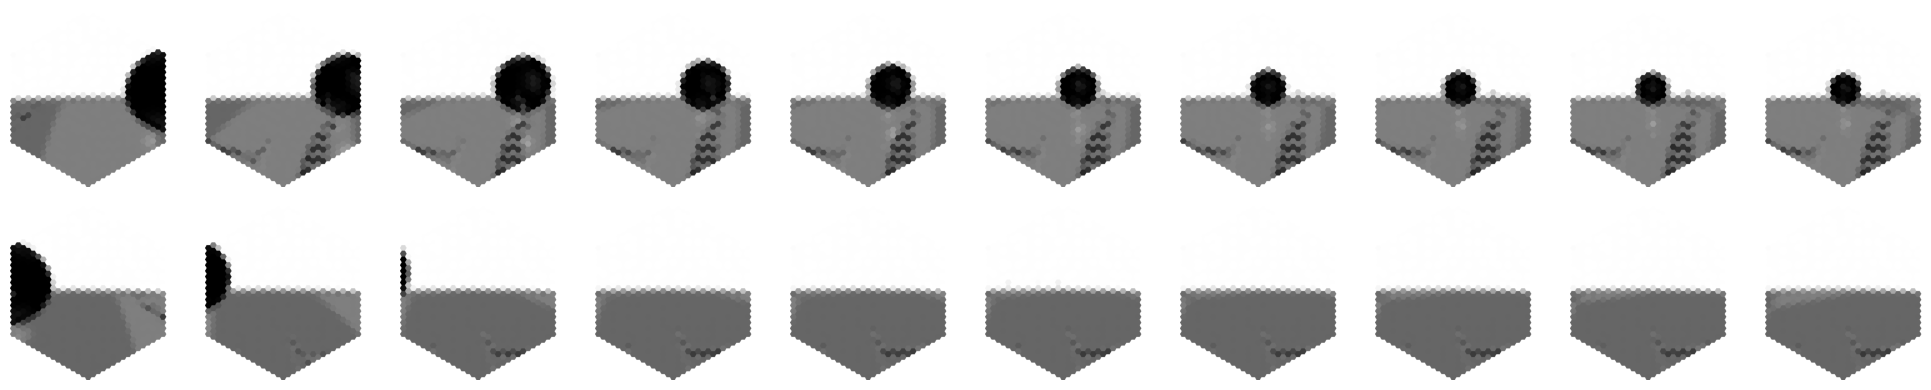

In [6]:
fig, axs = plt.subplots(2, 10, figsize=(20, 4), tight_layout=True)
for i, visual_obs in enumerate(visual_hist):
    human_readable_img_left = vision.hex_pxls_to_human_readable(visual_obs[0], vision.ommatidia_id_map)
    axs[0, i].imshow(human_readable_img_left, cmap="gray", vmin=0, vmax=255)
    axs[0, i].axis("off")
    human_readable_img_right = vision.hex_pxls_to_human_readable(visual_obs[1], vision.ommatidia_id_map)
    axs[1, i].imshow(human_readable_img_right, cmap="gray", vmin=0, vmax=255)
    axs[1, i].axis("off")

(-0.01, 0.3)

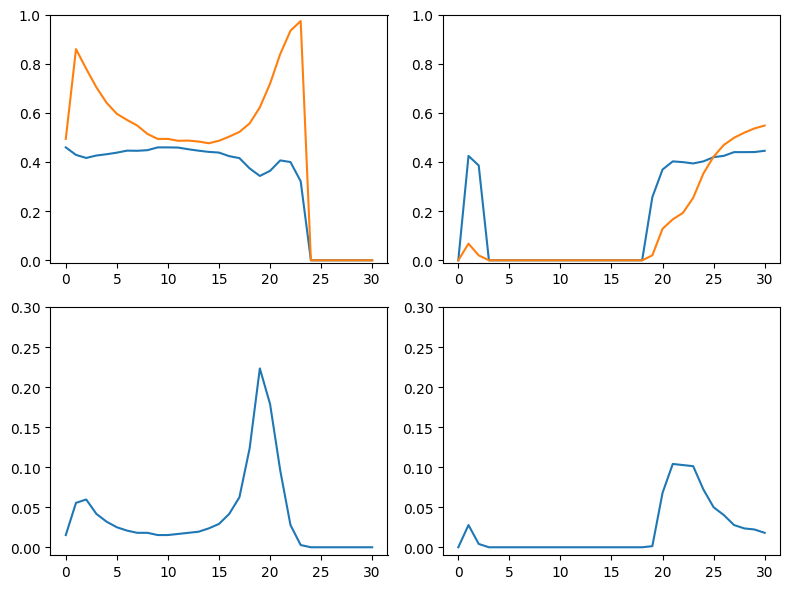

In [7]:
obs_hist = np.array(obs_hist)
fig, axs = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
axs[0, 0].plot(obs_hist[:, 0])
axs[0, 0].plot(obs_hist[:, 1])
axs[0, 0].set_ylim(-0.01, 1)
axs[1, 0].plot(obs_hist[:, 2])
axs[1, 0].set_ylim(-0.01, 0.3)

axs[0, 1].plot(obs_hist[:, 3])
axs[0, 1].plot(obs_hist[:, 4])
axs[0, 1].set_ylim(-0.01, 1)
axs[1, 1].plot(obs_hist[:, 5])
axs[1, 1].set_ylim(-0.01, 0.3)

In [8]:
arena = MovingObjArena(init_ball_pos=(5, 0, 2), move_speed=40)
sim_params = MuJoCoParameters(render_playspeed=0.2, render_camera="Animat/camera_top_zoomout", vision_refresh_rate=25)
task = NMFVisualTaxis(
    sim_params=sim_params,
    arena=arena,
    decision_dt=0.05,
    n_stabilisation_steps=5000,
    obj_threshold=50,
)
env_checker.check_env(task)

In [9]:
np.random.seed(0)
sb3.common.utils.set_random_seed(0, using_cuda=True)

start_from = None
train = True

log_dir = "logs/object_tracking_sac2c"
checkpoint_callback = callbacks.CheckpointCallback(
  save_freq=1000,
  save_path=log_dir,
  name_prefix="object_tracking_sac2c",
  save_replay_buffer=True,
  save_vecnormalize=True,
)
my_logger = logger.configure(log_dir, ["tensorboard", "stdout", "csv"])
model = sb3.SAC("MlpPolicy", env=task, policy_kwargs={"net_arch": [16, 16]}, verbose=2, learning_rate=0.01)
if start_from is not None:
    model = sb3.SAC.load(start_from)
model.set_logger(my_logger)

if train:
    model.learn(total_timesteps=10_000, progress_bar=True, callback=checkpoint_callback)
    model.save("models/object_tracking_sac2c")

Logging to logs/object_tracking_sac2c
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.75     |
|    ep_rew_mean     | -23      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1        |
|    time_elapsed    | 26       |
|    total_timesteps | 27       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.25     |
|    ep_rew_mean     | -23.7    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 0        |
|    time_elapsed    | 58       |
|    total_timesteps | 58       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.33     |
|    ep_rew_mean     | -23.6    |
| time/              |          |
|    episodes        | 12       |
|    fps             | 1        |
|    time_elapsed    | 87       |
|    total_timesteps | 88       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.06     |
|    ep_rew_mean     | -23.4    |
| time/              |          |
|    episodes        | 16       |
|    fps             | 0        |
|    time_elapsed    | 114      |
|    total_timesteps | 113      |
| train/             |          |
|    actor_loss      | -0.233   |
|    critic_loss     | 32.3     |
|    ent_coef        | 0.896    |
|    ent_coef_loss   | -0.369   |
|    learning_rate   | 0.01     |
|    n_updates       | 12       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.3      |
|    ep_rew_mean     | -23.5    |
| time/              |          |
|    episodes        | 20       |
|    fps             | 0        |
|    time_elapsed    | 147      |
|    total_timesteps | 146      |
| train/             |          |
|    actor_loss      | 2.26     |
|    critic_loss     | 21.2     |
|    ent_coef        | 0.645    |
|    ent_coef_loss   | -1.44    |
|    learning_rate   | 0.01     |
|    n_updates       | 45       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.5      |
|    ep_rew_mean     | -23.6    |
| time/              |          |
|    episodes        | 24       |
|    fps             | 0        |
|    time_elapsed    | 182      |
|    total_timesteps | 180      |
| train/             |          |
|    actor_loss      | 2.35     |
|    critic_loss     | 18       |
|    ent_coef        | 0.46     |
|    ent_coef_loss   | -2.49    |
|    learning_rate   | 0.01     |
|    n_updates       | 79       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.89     |
|    ep_rew_mean     | -23.7    |
| time/              |          |
|    episodes        | 28       |
|    fps             | 0        |
|    time_elapsed    | 223      |
|    total_timesteps | 221      |
| train/             |          |
|    actor_loss      | 3.18     |
|    critic_loss     | 16       |
|    ent_coef        | 0.312    |
|    ent_coef_loss   | -2.34    |
|    learning_rate   | 0.01     |
|    n_updates       | 120      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.03     |
|    ep_rew_mean     | -23.9    |
| time/              |          |
|    episodes        | 32       |
|    fps             | 0        |
|    time_elapsed    | 260      |
|    total_timesteps | 257      |
| train/             |          |
|    actor_loss      | 3.32     |
|    critic_loss     | 14.8     |
|    ent_coef        | 0.24     |
|    ent_coef_loss   | -3.44    |
|    learning_rate   | 0.01     |
|    n_updates       | 156      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.19     |
|    ep_rew_mean     | -24      |
| time/              |          |
|    episodes        | 36       |
|    fps             | 0        |
|    time_elapsed    | 298      |
|    total_timesteps | 295      |
| train/             |          |
|    actor_loss      | 3.86     |
|    critic_loss     | 14.1     |
|    ent_coef        | 0.179    |
|    ent_coef_loss   | -2.64    |
|    learning_rate   | 0.01     |
|    n_updates       | 194      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.12     |
|    ep_rew_mean     | -24      |
| time/              |          |
|    episodes        | 40       |
|    fps             | 0        |
|    time_elapsed    | 328      |
|    total_timesteps | 325      |
| train/             |          |
|    actor_loss      | 3.77     |
|    critic_loss     | 12.3     |
|    ent_coef        | 0.146    |
|    ent_coef_loss   | -2.04    |
|    learning_rate   | 0.01     |
|    n_updates       | 224      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.61     |
|    ep_rew_mean     | -24.3    |
| time/              |          |
|    episodes        | 44       |
|    fps             | 0        |
|    time_elapsed    | 379      |
|    total_timesteps | 379      |
| train/             |          |
|    actor_loss      | 4.11     |
|    critic_loss     | 9.53     |
|    ent_coef        | 0.114    |
|    ent_coef_loss   | -2.46    |
|    learning_rate   | 0.01     |
|    n_updates       | 278      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.6      |
|    ep_rew_mean     | -24.3    |
| time/              |          |
|    episodes        | 48       |
|    fps             | 1        |
|    time_elapsed    | 411      |
|    total_timesteps | 413      |
| train/             |          |
|    actor_loss      | 4.39     |
|    critic_loss     | 10.7     |
|    ent_coef        | 0.0991   |
|    ent_coef_loss   | -3.22    |
|    learning_rate   | 0.01     |
|    n_updates       | 312      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.6      |
|    ep_rew_mean     | -24.3    |
| time/              |          |
|    episodes        | 52       |
|    fps             | 1        |
|    time_elapsed    | 440      |
|    total_timesteps | 447      |
| train/             |          |
|    actor_loss      | 4.98     |
|    critic_loss     | 12.7     |
|    ent_coef        | 0.087    |
|    ent_coef_loss   | -1.67    |
|    learning_rate   | 0.01     |
|    n_updates       | 346      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.75     |
|    ep_rew_mean     | -24.3    |
| time/              |          |
|    episodes        | 56       |
|    fps             | 1        |
|    time_elapsed    | 479      |
|    total_timesteps | 490      |
| train/             |          |
|    actor_loss      | 4.97     |
|    critic_loss     | 9.27     |
|    ent_coef        | 0.0714   |
|    ent_coef_loss   | -0.695   |
|    learning_rate   | 0.01     |
|    n_updates       | 389      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.65     |
|    ep_rew_mean     | -24.2    |
| time/              |          |
|    episodes        | 60       |
|    fps             | 1        |
|    time_elapsed    | 504      |
|    total_timesteps | 519      |
| train/             |          |
|    actor_loss      | 5.33     |
|    critic_loss     | 7.84     |
|    ent_coef        | 0.0642   |
|    ent_coef_loss   | -2.58    |
|    learning_rate   | 0.01     |
|    n_updates       | 418      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.8      |
|    ep_rew_mean     | -24.3    |
| time/              |          |
|    episodes        | 64       |
|    fps             | 1        |
|    time_elapsed    | 542      |
|    total_timesteps | 563      |
| train/             |          |
|    actor_loss      | 6.35     |
|    critic_loss     | 7.11     |
|    ent_coef        | 0.0553   |
|    ent_coef_loss   | -0.973   |
|    learning_rate   | 0.01     |
|    n_updates       | 462      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.81     |
|    ep_rew_mean     | -24.2    |
| time/              |          |
|    episodes        | 68       |
|    fps             | 1        |
|    time_elapsed    | 573      |
|    total_timesteps | 599      |
| train/             |          |
|    actor_loss      | 6.17     |
|    critic_loss     | 6.93     |
|    ent_coef        | 0.0502   |
|    ent_coef_loss   | 0.453    |
|    learning_rate   | 0.01     |
|    n_updates       | 498      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9        |
|    ep_rew_mean     | -24.3    |
| time/              |          |
|    episodes        | 72       |
|    fps             | 1        |
|    time_elapsed    | 614      |
|    total_timesteps | 648      |
| train/             |          |
|    actor_loss      | 6.98     |
|    critic_loss     | 6.43     |
|    ent_coef        | 0.0431   |
|    ent_coef_loss   | 1.09     |
|    learning_rate   | 0.01     |
|    n_updates       | 547      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.2      |
|    ep_rew_mean     | -24.3    |
| time/              |          |
|    episodes        | 76       |
|    fps             | 1        |
|    time_elapsed    | 658      |
|    total_timesteps | 699      |
| train/             |          |
|    actor_loss      | 7.08     |
|    critic_loss     | 4.25     |
|    ent_coef        | 0.041    |
|    ent_coef_loss   | -2.63    |
|    learning_rate   | 0.01     |
|    n_updates       | 598      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.28     |
|    ep_rew_mean     | -24.4    |
| time/              |          |
|    episodes        | 80       |
|    fps             | 1        |
|    time_elapsed    | 696      |
|    total_timesteps | 742      |
| train/             |          |
|    actor_loss      | 7.18     |
|    critic_loss     | 3.07     |
|    ent_coef        | 0.0399   |
|    ent_coef_loss   | -1.19    |
|    learning_rate   | 0.01     |
|    n_updates       | 641      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.31     |
|    ep_rew_mean     | -24.4    |
| time/              |          |
|    episodes        | 84       |
|    fps             | 1        |
|    time_elapsed    | 733      |
|    total_timesteps | 782      |
| train/             |          |
|    actor_loss      | 7.64     |
|    critic_loss     | 3.53     |
|    ent_coef        | 0.038    |
|    ent_coef_loss   | 0.148    |
|    learning_rate   | 0.01     |
|    n_updates       | 681      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.42     |
|    ep_rew_mean     | -24.4    |
| time/              |          |
|    episodes        | 88       |
|    fps             | 1        |
|    time_elapsed    | 779      |
|    total_timesteps | 829      |
| train/             |          |
|    actor_loss      | 8.12     |
|    critic_loss     | 2.48     |
|    ent_coef        | 0.037    |
|    ent_coef_loss   | -0.306   |
|    learning_rate   | 0.01     |
|    n_updates       | 728      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.46     |
|    ep_rew_mean     | -24.4    |
| time/              |          |
|    episodes        | 92       |
|    fps             | 1        |
|    time_elapsed    | 819      |
|    total_timesteps | 870      |
| train/             |          |
|    actor_loss      | 8.73     |
|    critic_loss     | 3.44     |
|    ent_coef        | 0.0372   |
|    ent_coef_loss   | 1.2      |
|    learning_rate   | 0.01     |
|    n_updates       | 769      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.5      |
|    ep_rew_mean     | -24.4    |
| time/              |          |
|    episodes        | 96       |
|    fps             | 1        |
|    time_elapsed    | 861      |
|    total_timesteps | 912      |
| train/             |          |
|    actor_loss      | 8.55     |
|    critic_loss     | 2.76     |
|    ent_coef        | 0.036    |
|    ent_coef_loss   | -1.72    |
|    learning_rate   | 0.01     |
|    n_updates       | 811      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.86     |
|    ep_rew_mean     | -24      |
| time/              |          |
|    episodes        | 100      |
|    fps             | 1        |
|    time_elapsed    | 936      |
|    total_timesteps | 986      |
| train/             |          |
|    actor_loss      | 9.34     |
|    critic_loss     | 2.49     |
|    ent_coef        | 0.0378   |
|    ent_coef_loss   | 0.66     |
|    learning_rate   | 0.01     |
|    n_updates       | 885      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.2     |
|    ep_rew_mean     | -23.7    |
| time/              |          |
|    episodes        | 104      |
|    fps             | 1        |
|    time_elapsed    | 1000     |
|    total_timesteps | 1050     |
| train/             |          |
|    actor_loss      | 9.43     |
|    critic_loss     | 1.66     |
|    ent_coef        | 0.0412   |
|    ent_coef_loss   | -0.166   |
|    learning_rate   | 0.01     |
|    n_updates       | 949      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.6     |
|    ep_rew_mean     | -23.2    |
| time/              |          |
|    episodes        | 108      |
|    fps             | 1        |
|    time_elapsed    | 1068     |
|    total_timesteps | 1119     |
| train/             |          |
|    actor_loss      | 9.83     |
|    critic_loss     | 1.53     |
|    ent_coef        | 0.0452   |
|    ent_coef_loss   | 1.56     |
|    learning_rate   | 0.01     |
|    n_updates       | 1018     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.9     |
|    ep_rew_mean     | -23.1    |
| time/              |          |
|    episodes        | 112      |
|    fps             | 1        |
|    time_elapsed    | 1133     |
|    total_timesteps | 1183     |
| train/             |          |
|    actor_loss      | 10.5     |
|    critic_loss     | 2.72     |
|    ent_coef        | 0.0487   |
|    ent_coef_loss   | 0.845    |
|    learning_rate   | 0.01     |
|    n_updates       | 1082     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.4     |
|    ep_rew_mean     | -22.6    |
| time/              |          |
|    episodes        | 116      |
|    fps             | 1        |
|    time_elapsed    | 1205     |
|    total_timesteps | 1255     |
| train/             |          |
|    actor_loss      | 10.4     |
|    critic_loss     | 1.62     |
|    ent_coef        | 0.0536   |
|    ent_coef_loss   | 0.166    |
|    learning_rate   | 0.01     |
|    n_updates       | 1154     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.8     |
|    ep_rew_mean     | -22.5    |
| time/              |          |
|    episodes        | 120      |
|    fps             | 1        |
|    time_elapsed    | 1278     |
|    total_timesteps | 1328     |
| train/             |          |
|    actor_loss      | 10.4     |
|    critic_loss     | 1.4      |
|    ent_coef        | 0.0577   |
|    ent_coef_loss   | 0.00255  |
|    learning_rate   | 0.01     |
|    n_updates       | 1227     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.1     |
|    ep_rew_mean     | -22.5    |
| time/              |          |
|    episodes        | 124      |
|    fps             | 1        |
|    time_elapsed    | 1339     |
|    total_timesteps | 1390     |
| train/             |          |
|    actor_loss      | 10.8     |
|    critic_loss     | 1.53     |
|    ent_coef        | 0.063    |
|    ent_coef_loss   | 0.372    |
|    learning_rate   | 0.01     |
|    n_updates       | 1289     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.5     |
|    ep_rew_mean     | -22.2    |
| time/              |          |
|    episodes        | 128      |
|    fps             | 1        |
|    time_elapsed    | 1416     |
|    total_timesteps | 1468     |
| train/             |          |
|    actor_loss      | 11.2     |
|    critic_loss     | 1.5      |
|    ent_coef        | 0.0627   |
|    ent_coef_loss   | -0.401   |
|    learning_rate   | 0.01     |
|    n_updates       | 1367     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.8     |
|    ep_rew_mean     | -22.2    |
| time/              |          |
|    episodes        | 132      |
|    fps             | 1        |
|    time_elapsed    | 1483     |
|    total_timesteps | 1536     |
| train/             |          |
|    actor_loss      | 11.5     |
|    critic_loss     | 1.57     |
|    ent_coef        | 0.0622   |
|    ent_coef_loss   | -0.147   |
|    learning_rate   | 0.01     |
|    n_updates       | 1435     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.1     |
|    ep_rew_mean     | -21.9    |
| time/              |          |
|    episodes        | 136      |
|    fps             | 1        |
|    time_elapsed    | 1554     |
|    total_timesteps | 1609     |
| train/             |          |
|    actor_loss      | 11.8     |
|    critic_loss     | 1.52     |
|    ent_coef        | 0.0599   |
|    ent_coef_loss   | 0.00217  |
|    learning_rate   | 0.01     |
|    n_updates       | 1508     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.7     |
|    ep_rew_mean     | -21.4    |
| time/              |          |
|    episodes        | 140      |
|    fps             | 1        |
|    time_elapsed    | 1637     |
|    total_timesteps | 1693     |
| train/             |          |
|    actor_loss      | 11.8     |
|    critic_loss     | 1.12     |
|    ent_coef        | 0.0613   |
|    ent_coef_loss   | -0.0154  |
|    learning_rate   | 0.01     |
|    n_updates       | 1592     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.9     |
|    ep_rew_mean     | -20.7    |
| time/              |          |
|    episodes        | 144      |
|    fps             | 1        |
|    time_elapsed    | 1707     |
|    total_timesteps | 1774     |
| train/             |          |
|    actor_loss      | 11.9     |
|    critic_loss     | 0.923    |
|    ent_coef        | 0.0604   |
|    ent_coef_loss   | 0.331    |
|    learning_rate   | 0.01     |
|    n_updates       | 1673     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.4     |
|    ep_rew_mean     | -20.3    |
| time/              |          |
|    episodes        | 148      |
|    fps             | 1        |
|    time_elapsed    | 1777     |
|    total_timesteps | 1856     |
| train/             |          |
|    actor_loss      | 12.3     |
|    critic_loss     | 1.11     |
|    ent_coef        | 0.0647   |
|    ent_coef_loss   | 0.46     |
|    learning_rate   | 0.01     |
|    n_updates       | 1755     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.8     |
|    ep_rew_mean     | -20.1    |
| time/              |          |
|    episodes        | 152      |
|    fps             | 1        |
|    time_elapsed    | 1841     |
|    total_timesteps | 1930     |
| train/             |          |
|    actor_loss      | 12.6     |
|    critic_loss     | 0.803    |
|    ent_coef        | 0.0654   |
|    ent_coef_loss   | 0.256    |
|    learning_rate   | 0.01     |
|    n_updates       | 1829     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.1     |
|    ep_rew_mean     | -19.8    |
| time/              |          |
|    episodes        | 156      |
|    fps             | 1        |
|    time_elapsed    | 1904     |
|    total_timesteps | 2004     |
| train/             |          |
|    actor_loss      | 12.6     |
|    critic_loss     | 0.705    |
|    ent_coef        | 0.0625   |
|    ent_coef_loss   | 0.261    |
|    learning_rate   | 0.01     |
|    n_updates       | 1903     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.7     |
|    ep_rew_mean     | -19.4    |
| time/              |          |
|    episodes        | 160      |
|    fps             | 1        |
|    time_elapsed    | 1977     |
|    total_timesteps | 2088     |
| train/             |          |
|    actor_loss      | 12.8     |
|    critic_loss     | 0.734    |
|    ent_coef        | 0.0608   |
|    ent_coef_loss   | 0.195    |
|    learning_rate   | 0.01     |
|    n_updates       | 1987     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.9     |
|    ep_rew_mean     | -19.3    |
| time/              |          |
|    episodes        | 164      |
|    fps             | 1        |
|    time_elapsed    | 2035     |
|    total_timesteps | 2156     |
| train/             |          |
|    actor_loss      | 12.9     |
|    critic_loss     | 0.795    |
|    ent_coef        | 0.0648   |
|    ent_coef_loss   | -0.253   |
|    learning_rate   | 0.01     |
|    n_updates       | 2055     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.4     |
|    ep_rew_mean     | -18.8    |
| time/              |          |
|    episodes        | 168      |
|    fps             | 1        |
|    time_elapsed    | 2107     |
|    total_timesteps | 2240     |
| train/             |          |
|    actor_loss      | 13       |
|    critic_loss     | 0.946    |
|    ent_coef        | 0.0664   |
|    ent_coef_loss   | -0.122   |
|    learning_rate   | 0.01     |
|    n_updates       | 2139     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.8     |
|    ep_rew_mean     | -18.1    |
| time/              |          |
|    episodes        | 172      |
|    fps             | 1        |
|    time_elapsed    | 2178     |
|    total_timesteps | 2324     |
| train/             |          |
|    actor_loss      | 13.3     |
|    critic_loss     | 0.909    |
|    ent_coef        | 0.0671   |
|    ent_coef_loss   | -0.0135  |
|    learning_rate   | 0.01     |
|    n_updates       | 2223     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.9     |
|    ep_rew_mean     | -17.7    |
| time/              |          |
|    episodes        | 176      |
|    fps             | 1        |
|    time_elapsed    | 2232     |
|    total_timesteps | 2388     |
| train/             |          |
|    actor_loss      | 13.7     |
|    critic_loss     | 0.822    |
|    ent_coef        | 0.065    |
|    ent_coef_loss   | -0.473   |
|    learning_rate   | 0.01     |
|    n_updates       | 2287     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.2     |
|    ep_rew_mean     | -17.2    |
| time/              |          |
|    episodes        | 180      |
|    fps             | 1        |
|    time_elapsed    | 2293     |
|    total_timesteps | 2462     |
| train/             |          |
|    actor_loss      | 13.8     |
|    critic_loss     | 0.811    |
|    ent_coef        | 0.0667   |
|    ent_coef_loss   | -0.106   |
|    learning_rate   | 0.01     |
|    n_updates       | 2361     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.6     |
|    ep_rew_mean     | -16.5    |
| time/              |          |
|    episodes        | 184      |
|    fps             | 1        |
|    time_elapsed    | 2359     |
|    total_timesteps | 2539     |
| train/             |          |
|    actor_loss      | 14       |
|    critic_loss     | 0.667    |
|    ent_coef        | 0.0626   |
|    ent_coef_loss   | -0.126   |
|    learning_rate   | 0.01     |
|    n_updates       | 2438     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | -16.2    |
| time/              |          |
|    episodes        | 188      |
|    fps             | 1        |
|    time_elapsed    | 2429     |
|    total_timesteps | 2620     |
| train/             |          |
|    actor_loss      | 14.1     |
|    critic_loss     | 0.633    |
|    ent_coef        | 0.0562   |
|    ent_coef_loss   | -0.0818  |
|    learning_rate   | 0.01     |
|    n_updates       | 2519     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | -15.7    |
| time/              |          |
|    episodes        | 192      |
|    fps             | 1        |
|    time_elapsed    | 2498     |
|    total_timesteps | 2694     |
| train/             |          |
|    actor_loss      | 14.3     |
|    critic_loss     | 0.705    |
|    ent_coef        | 0.0584   |
|    ent_coef_loss   | 0.482    |
|    learning_rate   | 0.01     |
|    n_updates       | 2593     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | -15.1    |
| time/              |          |
|    episodes        | 196      |
|    fps             | 1        |
|    time_elapsed    | 2573     |
|    total_timesteps | 2771     |
| train/             |          |
|    actor_loss      | 14.4     |
|    critic_loss     | 1.13     |
|    ent_coef        | 0.0555   |
|    ent_coef_loss   | -1.09    |
|    learning_rate   | 0.01     |
|    n_updates       | 2670     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | -14.9    |
| time/              |          |
|    episodes        | 200      |
|    fps             | 1        |
|    time_elapsed    | 2654     |
|    total_timesteps | 2852     |
| train/             |          |
|    actor_loss      | 14.6     |
|    critic_loss     | 0.88     |
|    ent_coef        | 0.058    |
|    ent_coef_loss   | -0.856   |
|    learning_rate   | 0.01     |
|    n_updates       | 2751     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.8     |
|    ep_rew_mean     | -14.9    |
| time/              |          |
|    episodes        | 204      |
|    fps             | 1        |
|    time_elapsed    | 2729     |
|    total_timesteps | 2927     |
| train/             |          |
|    actor_loss      | 15       |
|    critic_loss     | 1.01     |
|    ent_coef        | 0.0561   |
|    ent_coef_loss   | -1.27    |
|    learning_rate   | 0.01     |
|    n_updates       | 2826     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | -14.7    |
| time/              |          |
|    episodes        | 208      |
|    fps             | 1        |
|    time_elapsed    | 2806     |
|    total_timesteps | 3004     |
| train/             |          |
|    actor_loss      | 14.9     |
|    critic_loss     | 0.795    |
|    ent_coef        | 0.0486   |
|    ent_coef_loss   | -0.249   |
|    learning_rate   | 0.01     |
|    n_updates       | 2903     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | -14.2    |
| time/              |          |
|    episodes        | 212      |
|    fps             | 1        |
|    time_elapsed    | 2880     |
|    total_timesteps | 3078     |
| train/             |          |
|    actor_loss      | 15       |
|    critic_loss     | 0.95     |
|    ent_coef        | 0.0541   |
|    ent_coef_loss   | -0.0755  |
|    learning_rate   | 0.01     |
|    n_updates       | 2977     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19       |
|    ep_rew_mean     | -14      |
| time/              |          |
|    episodes        | 216      |
|    fps             | 1        |
|    time_elapsed    | 2959     |
|    total_timesteps | 3158     |
| train/             |          |
|    actor_loss      | 15.1     |
|    critic_loss     | 0.814    |
|    ent_coef        | 0.0526   |
|    ent_coef_loss   | 0.352    |
|    learning_rate   | 0.01     |
|    n_updates       | 3057     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | -13.5    |
| time/              |          |
|    episodes        | 220      |
|    fps             | 1        |
|    time_elapsed    | 3033     |
|    total_timesteps | 3234     |
| train/             |          |
|    actor_loss      | 15.4     |
|    critic_loss     | 0.847    |
|    ent_coef        | 0.0584   |
|    ent_coef_loss   | -0.059   |
|    learning_rate   | 0.01     |
|    n_updates       | 3133     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 224      |
|    fps             | 1        |
|    time_elapsed    | 3111     |
|    total_timesteps | 3318     |
| train/             |          |
|    actor_loss      | 15.1     |
|    critic_loss     | 1.24     |
|    ent_coef        | 0.0518   |
|    ent_coef_loss   | 0.712    |
|    learning_rate   | 0.01     |
|    n_updates       | 3217     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.2     |
|    ep_rew_mean     | -12.9    |
| time/              |          |
|    episodes        | 228      |
|    fps             | 1        |
|    time_elapsed    | 3172     |
|    total_timesteps | 3389     |
| train/             |          |
|    actor_loss      | 15.6     |
|    critic_loss     | 0.973    |
|    ent_coef        | 0.0601   |
|    ent_coef_loss   | -0.6     |
|    learning_rate   | 0.01     |
|    n_updates       | 3288     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 232      |
|    fps             | 1        |
|    time_elapsed    | 3242     |
|    total_timesteps | 3471     |
| train/             |          |
|    actor_loss      | 15.7     |
|    critic_loss     | 1.28     |
|    ent_coef        | 0.0569   |
|    ent_coef_loss   | 0.297    |
|    learning_rate   | 0.01     |
|    n_updates       | 3370     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 236      |
|    fps             | 1        |
|    time_elapsed    | 3301     |
|    total_timesteps | 3540     |
| train/             |          |
|    actor_loss      | 15.9     |
|    critic_loss     | 1.23     |
|    ent_coef        | 0.0553   |
|    ent_coef_loss   | -0.0202  |
|    learning_rate   | 0.01     |
|    n_updates       | 3439     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.2     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 240      |
|    fps             | 1        |
|    time_elapsed    | 3363     |
|    total_timesteps | 3613     |
| train/             |          |
|    actor_loss      | 15.9     |
|    critic_loss     | 1.15     |
|    ent_coef        | 0.0535   |
|    ent_coef_loss   | -0.0464  |
|    learning_rate   | 0.01     |
|    n_updates       | 3512     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 244      |
|    fps             | 1        |
|    time_elapsed    | 3426     |
|    total_timesteps | 3686     |
| train/             |          |
|    actor_loss      | 15.8     |
|    critic_loss     | 1.26     |
|    ent_coef        | 0.0488   |
|    ent_coef_loss   | 0.698    |
|    learning_rate   | 0.01     |
|    n_updates       | 3585     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | -11.4    |
| time/              |          |
|    episodes        | 248      |
|    fps             | 1        |
|    time_elapsed    | 3498     |
|    total_timesteps | 3770     |
| train/             |          |
|    actor_loss      | 16       |
|    critic_loss     | 1.03     |
|    ent_coef        | 0.0545   |
|    ent_coef_loss   | -0.928   |
|    learning_rate   | 0.01     |
|    n_updates       | 3669     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | -11.2    |
| time/              |          |
|    episodes        | 252      |
|    fps             | 1        |
|    time_elapsed    | 3562     |
|    total_timesteps | 3845     |
| train/             |          |
|    actor_loss      | 16.2     |
|    critic_loss     | 1.31     |
|    ent_coef        | 0.0504   |
|    ent_coef_loss   | -0.653   |
|    learning_rate   | 0.01     |
|    n_updates       | 3744     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | -10.8    |
| time/              |          |
|    episodes        | 256      |
|    fps             | 1        |
|    time_elapsed    | 3621     |
|    total_timesteps | 3914     |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 1.23     |
|    ent_coef        | 0.0475   |
|    ent_coef_loss   | 0.889    |
|    learning_rate   | 0.01     |
|    n_updates       | 3813     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19       |
|    ep_rew_mean     | -10.8    |
| time/              |          |
|    episodes        | 260      |
|    fps             | 1        |
|    time_elapsed    | 3683     |
|    total_timesteps | 3986     |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 1.4      |
|    ent_coef        | 0.0539   |
|    ent_coef_loss   | -0.256   |
|    learning_rate   | 0.01     |
|    n_updates       | 3885     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19       |
|    ep_rew_mean     | -10.1    |
| time/              |          |
|    episodes        | 264      |
|    fps             | 1        |
|    time_elapsed    | 3746     |
|    total_timesteps | 4060     |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 1.04     |
|    ent_coef        | 0.0477   |
|    ent_coef_loss   | 0.168    |
|    learning_rate   | 0.01     |
|    n_updates       | 3959     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | -10      |
| time/              |          |
|    episodes        | 268      |
|    fps             | 1        |
|    time_elapsed    | 3810     |
|    total_timesteps | 4134     |
| train/             |          |
|    actor_loss      | 16.8     |
|    critic_loss     | 1.24     |
|    ent_coef        | 0.0436   |
|    ent_coef_loss   | 1.12     |
|    learning_rate   | 0.01     |
|    n_updates       | 4033     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.8     |
|    ep_rew_mean     | -9.87    |
| time/              |          |
|    episodes        | 272      |
|    fps             | 1        |
|    time_elapsed    | 3867     |
|    total_timesteps | 4201     |
| train/             |          |
|    actor_loss      | 16.9     |
|    critic_loss     | 1.26     |
|    ent_coef        | 0.0469   |
|    ent_coef_loss   | -1.25    |
|    learning_rate   | 0.01     |
|    n_updates       | 4100     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19       |
|    ep_rew_mean     | -9.7     |
| time/              |          |
|    episodes        | 276      |
|    fps             | 1        |
|    time_elapsed    | 3938     |
|    total_timesteps | 4284     |
| train/             |          |
|    actor_loss      | 16.4     |
|    critic_loss     | 1.3      |
|    ent_coef        | 0.0516   |
|    ent_coef_loss   | 0.967    |
|    learning_rate   | 0.01     |
|    n_updates       | 4183     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19       |
|    ep_rew_mean     | -9.51    |
| time/              |          |
|    episodes        | 280      |
|    fps             | 1        |
|    time_elapsed    | 4005     |
|    total_timesteps | 4362     |
| train/             |          |
|    actor_loss      | 16.5     |
|    critic_loss     | 1.2      |
|    ent_coef        | 0.0505   |
|    ent_coef_loss   | -1.51    |
|    learning_rate   | 0.01     |
|    n_updates       | 4261     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | -9.53    |
| time/              |          |
|    episodes        | 284      |
|    fps             | 1        |
|    time_elapsed    | 4076     |
|    total_timesteps | 4445     |
| train/             |          |
|    actor_loss      | 17.1     |
|    critic_loss     | 1.31     |
|    ent_coef        | 0.049    |
|    ent_coef_loss   | -1.05    |
|    learning_rate   | 0.01     |
|    n_updates       | 4344     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | -8.87    |
| time/              |          |
|    episodes        | 288      |
|    fps             | 1        |
|    time_elapsed    | 4148     |
|    total_timesteps | 4529     |
| train/             |          |
|    actor_loss      | 16.7     |
|    critic_loss     | 1.47     |
|    ent_coef        | 0.0486   |
|    ent_coef_loss   | -1.11    |
|    learning_rate   | 0.01     |
|    n_updates       | 4428     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.2     |
|    ep_rew_mean     | -8.57    |
| time/              |          |
|    episodes        | 292      |
|    fps             | 1        |
|    time_elapsed    | 4220     |
|    total_timesteps | 4613     |
| train/             |          |
|    actor_loss      | 16.8     |
|    critic_loss     | 1.58     |
|    ent_coef        | 0.043    |
|    ent_coef_loss   | 0.866    |
|    learning_rate   | 0.01     |
|    n_updates       | 4512     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.2     |
|    ep_rew_mean     | -8.7     |
| time/              |          |
|    episodes        | 296      |
|    fps             | 1        |
|    time_elapsed    | 4290     |
|    total_timesteps | 4695     |
| train/             |          |
|    actor_loss      | 17       |
|    critic_loss     | 1.33     |
|    ent_coef        | 0.0423   |
|    ent_coef_loss   | -0.203   |
|    learning_rate   | 0.01     |
|    n_updates       | 4594     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.2     |
|    ep_rew_mean     | -8.71    |
| time/              |          |
|    episodes        | 300      |
|    fps             | 1        |
|    time_elapsed    | 4358     |
|    total_timesteps | 4774     |
| train/             |          |
|    actor_loss      | 17.1     |
|    critic_loss     | 1.56     |
|    ent_coef        | 0.0376   |
|    ent_coef_loss   | 1.03     |
|    learning_rate   | 0.01     |
|    n_updates       | 4673     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -8.28    |
| time/              |          |
|    episodes        | 304      |
|    fps             | 1        |
|    time_elapsed    | 4430     |
|    total_timesteps | 4858     |
| train/             |          |
|    actor_loss      | 17.4     |
|    critic_loss     | 1.34     |
|    ent_coef        | 0.0437   |
|    ent_coef_loss   | -0.88    |
|    learning_rate   | 0.01     |
|    n_updates       | 4757     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.2     |
|    ep_rew_mean     | -8.54    |
| time/              |          |
|    episodes        | 308      |
|    fps             | 1        |
|    time_elapsed    | 4490     |
|    total_timesteps | 4929     |
| train/             |          |
|    actor_loss      | 17.2     |
|    critic_loss     | 1.14     |
|    ent_coef        | 0.049    |
|    ent_coef_loss   | -1.92    |
|    learning_rate   | 0.01     |
|    n_updates       | 4828     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -8.73    |
| time/              |          |
|    episodes        | 312      |
|    fps             | 1        |
|    time_elapsed    | 4559     |
|    total_timesteps | 5009     |
| train/             |          |
|    actor_loss      | 17.3     |
|    critic_loss     | 1.06     |
|    ent_coef        | 0.0419   |
|    ent_coef_loss   | 1.03     |
|    learning_rate   | 0.01     |
|    n_updates       | 4908     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -8.6     |
| time/              |          |
|    episodes        | 316      |
|    fps             | 1        |
|    time_elapsed    | 4630     |
|    total_timesteps | 5093     |
| train/             |          |
|    actor_loss      | 17.1     |
|    critic_loss     | 1.44     |
|    ent_coef        | 0.0417   |
|    ent_coef_loss   | -0.536   |
|    learning_rate   | 0.01     |
|    n_updates       | 4992     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -8.12    |
| time/              |          |
|    episodes        | 320      |
|    fps             | 1        |
|    time_elapsed    | 4702     |
|    total_timesteps | 5177     |
| train/             |          |
|    actor_loss      | 17.5     |
|    critic_loss     | 1.08     |
|    ent_coef        | 0.0437   |
|    ent_coef_loss   | -0.878   |
|    learning_rate   | 0.01     |
|    n_updates       | 5076     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -8.18    |
| time/              |          |
|    episodes        | 324      |
|    fps             | 1        |
|    time_elapsed    | 4771     |
|    total_timesteps | 5257     |
| train/             |          |
|    actor_loss      | 17.4     |
|    critic_loss     | 1.4      |
|    ent_coef        | 0.0294   |
|    ent_coef_loss   | 2.05     |
|    learning_rate   | 0.01     |
|    n_updates       | 5156     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -8.01    |
| time/              |          |
|    episodes        | 328      |
|    fps             | 1        |
|    time_elapsed    | 4827     |
|    total_timesteps | 5322     |
| train/             |          |
|    actor_loss      | 17.6     |
|    critic_loss     | 1.72     |
|    ent_coef        | 0.033    |
|    ent_coef_loss   | -1.85    |
|    learning_rate   | 0.01     |
|    n_updates       | 5221     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -7.88    |
| time/              |          |
|    episodes        | 332      |
|    fps             | 1        |
|    time_elapsed    | 4900     |
|    total_timesteps | 5406     |
| train/             |          |
|    actor_loss      | 17.6     |
|    critic_loss     | 1.53     |
|    ent_coef        | 0.0368   |
|    ent_coef_loss   | 0.307    |
|    learning_rate   | 0.01     |
|    n_updates       | 5305     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -8.03    |
| time/              |          |
|    episodes        | 336      |
|    fps             | 1        |
|    time_elapsed    | 4954     |
|    total_timesteps | 5470     |
| train/             |          |
|    actor_loss      | 17.4     |
|    critic_loss     | 1.23     |
|    ent_coef        | 0.0367   |
|    ent_coef_loss   | 0.247    |
|    learning_rate   | 0.01     |
|    n_updates       | 5369     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.2     |
|    ep_rew_mean     | -7.9     |
| time/              |          |
|    episodes        | 340      |
|    fps             | 1        |
|    time_elapsed    | 5010     |
|    total_timesteps | 5535     |
| train/             |          |
|    actor_loss      | 17.4     |
|    critic_loss     | 1.87     |
|    ent_coef        | 0.0368   |
|    ent_coef_loss   | -0.469   |
|    learning_rate   | 0.01     |
|    n_updates       | 5434     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.2     |
|    ep_rew_mean     | -7.8     |
| time/              |          |
|    episodes        | 344      |
|    fps             | 1        |
|    time_elapsed    | 5076     |
|    total_timesteps | 5611     |
| train/             |          |
|    actor_loss      | 17.4     |
|    critic_loss     | 1.38     |
|    ent_coef        | 0.0318   |
|    ent_coef_loss   | 0.137    |
|    learning_rate   | 0.01     |
|    n_updates       | 5510     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.2     |
|    ep_rew_mean     | -8.27    |
| time/              |          |
|    episodes        | 348      |
|    fps             | 1        |
|    time_elapsed    | 5143     |
|    total_timesteps | 5689     |
| train/             |          |
|    actor_loss      | 17.5     |
|    critic_loss     | 1.33     |
|    ent_coef        | 0.0335   |
|    ent_coef_loss   | -0.547   |
|    learning_rate   | 0.01     |
|    n_updates       | 5588     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.2     |
|    ep_rew_mean     | -8.25    |
| time/              |          |
|    episodes        | 352      |
|    fps             | 1        |
|    time_elapsed    | 5209     |
|    total_timesteps | 5765     |
| train/             |          |
|    actor_loss      | 17.7     |
|    critic_loss     | 1.31     |
|    ent_coef        | 0.0343   |
|    ent_coef_loss   | -0.269   |
|    learning_rate   | 0.01     |
|    n_updates       | 5664     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -8.2     |
| time/              |          |
|    episodes        | 356      |
|    fps             | 1        |
|    time_elapsed    | 5274     |
|    total_timesteps | 5841     |
| train/             |          |
|    actor_loss      | 18       |
|    critic_loss     | 1.25     |
|    ent_coef        | 0.0342   |
|    ent_coef_loss   | -0.261   |
|    learning_rate   | 0.01     |
|    n_updates       | 5740     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -8.19    |
| time/              |          |
|    episodes        | 360      |
|    fps             | 1        |
|    time_elapsed    | 5339     |
|    total_timesteps | 5916     |
| train/             |          |
|    actor_loss      | 18       |
|    critic_loss     | 1.24     |
|    ent_coef        | 0.0357   |
|    ent_coef_loss   | -1.12    |
|    learning_rate   | 0.01     |
|    n_updates       | 5815     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -8.28    |
| time/              |          |
|    episodes        | 364      |
|    fps             | 1        |
|    time_elapsed    | 5408     |
|    total_timesteps | 5996     |
| train/             |          |
|    actor_loss      | 18.1     |
|    critic_loss     | 1.02     |
|    ent_coef        | 0.0307   |
|    ent_coef_loss   | 0.644    |
|    learning_rate   | 0.01     |
|    n_updates       | 5895     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -7.81    |
| time/              |          |
|    episodes        | 368      |
|    fps             | 1        |
|    time_elapsed    | 5480     |
|    total_timesteps | 6080     |
| train/             |          |
|    actor_loss      | 17.9     |
|    critic_loss     | 1.23     |
|    ent_coef        | 0.0357   |
|    ent_coef_loss   | 0.542    |
|    learning_rate   | 0.01     |
|    n_updates       | 5979     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | -7.78    |
| time/              |          |
|    episodes        | 372      |
|    fps             | 1        |
|    time_elapsed    | 5551     |
|    total_timesteps | 6162     |
| train/             |          |
|    actor_loss      | 18       |
|    critic_loss     | 1.57     |
|    ent_coef        | 0.0319   |
|    ent_coef_loss   | -1.7     |
|    learning_rate   | 0.01     |
|    n_updates       | 6061     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -7.68    |
| time/              |          |
|    episodes        | 376      |
|    fps             | 1        |
|    time_elapsed    | 5613     |
|    total_timesteps | 6234     |
| train/             |          |
|    actor_loss      | 17.8     |
|    critic_loss     | 1.49     |
|    ent_coef        | 0.03     |
|    ent_coef_loss   | -0.583   |
|    learning_rate   | 0.01     |
|    n_updates       | 6133     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -8.11    |
| time/              |          |
|    episodes        | 380      |
|    fps             | 1        |
|    time_elapsed    | 5676     |
|    total_timesteps | 6307     |
| train/             |          |
|    actor_loss      | 18.3     |
|    critic_loss     | 1.73     |
|    ent_coef        | 0.0351   |
|    ent_coef_loss   | -0.258   |
|    learning_rate   | 0.01     |
|    n_updates       | 6206     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -8.11    |
| time/              |          |
|    episodes        | 384      |
|    fps             | 1        |
|    time_elapsed    | 5735     |
|    total_timesteps | 6375     |
| train/             |          |
|    actor_loss      | 18.1     |
|    critic_loss     | 1.19     |
|    ent_coef        | 0.0328   |
|    ent_coef_loss   | -0.0393  |
|    learning_rate   | 0.01     |
|    n_updates       | 6274     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | -8.69    |
| time/              |          |
|    episodes        | 388      |
|    fps             | 1        |
|    time_elapsed    | 5790     |
|    total_timesteps | 6438     |
| train/             |          |
|    actor_loss      | 18       |
|    critic_loss     | 1.18     |
|    ent_coef        | 0.0366   |
|    ent_coef_loss   | 0.256    |
|    learning_rate   | 0.01     |
|    n_updates       | 6337     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | -8.98    |
| time/              |          |
|    episodes        | 392      |
|    fps             | 1        |
|    time_elapsed    | 5862     |
|    total_timesteps | 6521     |
| train/             |          |
|    actor_loss      | 18.1     |
|    critic_loss     | 1.16     |
|    ent_coef        | 0.0354   |
|    ent_coef_loss   | -0.741   |
|    learning_rate   | 0.01     |
|    n_updates       | 6420     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19       |
|    ep_rew_mean     | -8.94    |
| time/              |          |
|    episodes        | 396      |
|    fps             | 1        |
|    time_elapsed    | 5928     |
|    total_timesteps | 6598     |
| train/             |          |
|    actor_loss      | 18       |
|    critic_loss     | 0.841    |
|    ent_coef        | 0.0341   |
|    ent_coef_loss   | -0.887   |
|    learning_rate   | 0.01     |
|    n_updates       | 6497     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19       |
|    ep_rew_mean     | -9.01    |
| time/              |          |
|    episodes        | 400      |
|    fps             | 1        |
|    time_elapsed    | 5997     |
|    total_timesteps | 6678     |
| train/             |          |
|    actor_loss      | 18.2     |
|    critic_loss     | 1.55     |
|    ent_coef        | 0.0355   |
|    ent_coef_loss   | -0.169   |
|    learning_rate   | 0.01     |
|    n_updates       | 6577     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19       |
|    ep_rew_mean     | -8.83    |
| time/              |          |
|    episodes        | 404      |
|    fps             | 1        |
|    time_elapsed    | 6069     |
|    total_timesteps | 6762     |
| train/             |          |
|    actor_loss      | 18.1     |
|    critic_loss     | 1.7      |
|    ent_coef        | 0.0303   |
|    ent_coef_loss   | 1.2      |
|    learning_rate   | 0.01     |
|    n_updates       | 6661     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | -8.7     |
| time/              |          |
|    episodes        | 408      |
|    fps             | 1        |
|    time_elapsed    | 6133     |
|    total_timesteps | 6837     |
| train/             |          |
|    actor_loss      | 18.2     |
|    critic_loss     | 1.42     |
|    ent_coef        | 0.0366   |
|    ent_coef_loss   | 0.253    |
|    learning_rate   | 0.01     |
|    n_updates       | 6736     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | -8.68    |
| time/              |          |
|    episodes        | 412      |
|    fps             | 1        |
|    time_elapsed    | 6203     |
|    total_timesteps | 6918     |
| train/             |          |
|    actor_loss      | 18.2     |
|    critic_loss     | 1.42     |
|    ent_coef        | 0.0354   |
|    ent_coef_loss   | 0.393    |
|    learning_rate   | 0.01     |
|    n_updates       | 6817     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19       |
|    ep_rew_mean     | -8.84    |
| time/              |          |
|    episodes        | 416      |
|    fps             | 1        |
|    time_elapsed    | 6269     |
|    total_timesteps | 6995     |
| train/             |          |
|    actor_loss      | 18.4     |
|    critic_loss     | 1.11     |
|    ent_coef        | 0.0335   |
|    ent_coef_loss   | 0.209    |
|    learning_rate   | 0.01     |
|    n_updates       | 6894     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | -9.47    |
| time/              |          |
|    episodes        | 420      |
|    fps             | 1        |
|    time_elapsed    | 6330     |
|    total_timesteps | 7066     |
| train/             |          |
|    actor_loss      | 18.2     |
|    critic_loss     | 1.04     |
|    ent_coef        | 0.0313   |
|    ent_coef_loss   | 0.261    |
|    learning_rate   | 0.01     |
|    n_updates       | 6965     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | -9.52    |
| time/              |          |
|    episodes        | 424      |
|    fps             | 1        |
|    time_elapsed    | 6398     |
|    total_timesteps | 7146     |
| train/             |          |
|    actor_loss      | 18.4     |
|    critic_loss     | 1.36     |
|    ent_coef        | 0.0339   |
|    ent_coef_loss   | -1.48    |
|    learning_rate   | 0.01     |
|    n_updates       | 7045     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19       |
|    ep_rew_mean     | -9.12    |
| time/              |          |
|    episodes        | 428      |
|    fps             | 1        |
|    time_elapsed    | 6466     |
|    total_timesteps | 7225     |
| train/             |          |
|    actor_loss      | 18.3     |
|    critic_loss     | 1.41     |
|    ent_coef        | 0.0345   |
|    ent_coef_loss   | -0.196   |
|    learning_rate   | 0.01     |
|    n_updates       | 7124     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19       |
|    ep_rew_mean     | -9.39    |
| time/              |          |
|    episodes        | 432      |
|    fps             | 1        |
|    time_elapsed    | 6537     |
|    total_timesteps | 7309     |
| train/             |          |
|    actor_loss      | 18.5     |
|    critic_loss     | 1.47     |
|    ent_coef        | 0.0332   |
|    ent_coef_loss   | -0.664   |
|    learning_rate   | 0.01     |
|    n_updates       | 7208     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | -9.37    |
| time/              |          |
|    episodes        | 436      |
|    fps             | 1        |
|    time_elapsed    | 6601     |
|    total_timesteps | 7384     |
| train/             |          |
|    actor_loss      | 18       |
|    critic_loss     | 1.09     |
|    ent_coef        | 0.0293   |
|    ent_coef_loss   | 1.42     |
|    learning_rate   | 0.01     |
|    n_updates       | 7283     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -9.31    |
| time/              |          |
|    episodes        | 440      |
|    fps             | 1        |
|    time_elapsed    | 6669     |
|    total_timesteps | 7462     |
| train/             |          |
|    actor_loss      | 18.4     |
|    critic_loss     | 1.22     |
|    ent_coef        | 0.0311   |
|    ent_coef_loss   | 0.432    |
|    learning_rate   | 0.01     |
|    n_updates       | 7361     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.2     |
|    ep_rew_mean     | -9.34    |
| time/              |          |
|    episodes        | 444      |
|    fps             | 1        |
|    time_elapsed    | 6728     |
|    total_timesteps | 7531     |
| train/             |          |
|    actor_loss      | 18.3     |
|    critic_loss     | 1.18     |
|    ent_coef        | 0.0364   |
|    ent_coef_loss   | -0.198   |
|    learning_rate   | 0.01     |
|    n_updates       | 7430     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19       |
|    ep_rew_mean     | -9.82    |
| time/              |          |
|    episodes        | 448      |
|    fps             | 1        |
|    time_elapsed    | 6778     |
|    total_timesteps | 7588     |
| train/             |          |
|    actor_loss      | 18.8     |
|    critic_loss     | 1.16     |
|    ent_coef        | 0.0284   |
|    ent_coef_loss   | 2.22     |
|    learning_rate   | 0.01     |
|    n_updates       | 7487     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.8     |
|    ep_rew_mean     | -9.66    |
| time/              |          |
|    episodes        | 452      |
|    fps             | 1        |
|    time_elapsed    | 6826     |
|    total_timesteps | 7644     |
| train/             |          |
|    actor_loss      | 18.7     |
|    critic_loss     | 1.28     |
|    ent_coef        | 0.0334   |
|    ent_coef_loss   | -0.637   |
|    learning_rate   | 0.01     |
|    n_updates       | 7543     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | -10      |
| time/              |          |
|    episodes        | 456      |
|    fps             | 1        |
|    time_elapsed    | 6873     |
|    total_timesteps | 7698     |
| train/             |          |
|    actor_loss      | 18.3     |
|    critic_loss     | 1.1      |
|    ent_coef        | 0.032    |
|    ent_coef_loss   | 0.0636   |
|    learning_rate   | 0.01     |
|    n_updates       | 7597     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | -9.92    |
| time/              |          |
|    episodes        | 460      |
|    fps             | 1        |
|    time_elapsed    | 6942     |
|    total_timesteps | 7778     |
| train/             |          |
|    actor_loss      | 18.6     |
|    critic_loss     | 1.42     |
|    ent_coef        | 0.0305   |
|    ent_coef_loss   | -0.495   |
|    learning_rate   | 0.01     |
|    n_updates       | 7677     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | -10.2    |
| time/              |          |
|    episodes        | 464      |
|    fps             | 1        |
|    time_elapsed    | 7004     |
|    total_timesteps | 7851     |
| train/             |          |
|    actor_loss      | 18.3     |
|    critic_loss     | 1.72     |
|    ent_coef        | 0.0349   |
|    ent_coef_loss   | -0.0794  |
|    learning_rate   | 0.01     |
|    n_updates       | 7750     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | -11.2    |
| time/              |          |
|    episodes        | 468      |
|    fps             | 1        |
|    time_elapsed    | 7053     |
|    total_timesteps | 7907     |
| train/             |          |
|    actor_loss      | 18.5     |
|    critic_loss     | 1.41     |
|    ent_coef        | 0.0232   |
|    ent_coef_loss   | 0.662    |
|    learning_rate   | 0.01     |
|    n_updates       | 7806     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | -11.3    |
| time/              |          |
|    episodes        | 472      |
|    fps             | 1        |
|    time_elapsed    | 7126     |
|    total_timesteps | 7991     |
| train/             |          |
|    actor_loss      | 18.3     |
|    critic_loss     | 1.66     |
|    ent_coef        | 0.0308   |
|    ent_coef_loss   | -0.0905  |
|    learning_rate   | 0.01     |
|    n_updates       | 7890     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | -11.3    |
| time/              |          |
|    episodes        | 476      |
|    fps             | 1        |
|    time_elapsed    | 7197     |
|    total_timesteps | 8074     |
| train/             |          |
|    actor_loss      | 18.5     |
|    critic_loss     | 1.36     |
|    ent_coef        | 0.0335   |
|    ent_coef_loss   | -1.24    |
|    learning_rate   | 0.01     |
|    n_updates       | 7973     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | -11.3    |
| time/              |          |
|    episodes        | 480      |
|    fps             | 1        |
|    time_elapsed    | 7257     |
|    total_timesteps | 8143     |
| train/             |          |
|    actor_loss      | 18.7     |
|    critic_loss     | 1.18     |
|    ent_coef        | 0.036    |
|    ent_coef_loss   | 0.26     |
|    learning_rate   | 0.01     |
|    n_updates       | 8042     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | -11.6    |
| time/              |          |
|    episodes        | 484      |
|    fps             | 1        |
|    time_elapsed    | 7317     |
|    total_timesteps | 8213     |
| train/             |          |
|    actor_loss      | 18.8     |
|    critic_loss     | 1.26     |
|    ent_coef        | 0.0317   |
|    ent_coef_loss   | 1.39     |
|    learning_rate   | 0.01     |
|    n_updates       | 8112     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | -11.5    |
| time/              |          |
|    episodes        | 488      |
|    fps             | 1        |
|    time_elapsed    | 7386     |
|    total_timesteps | 8293     |
| train/             |          |
|    actor_loss      | 18.5     |
|    critic_loss     | 1.54     |
|    ent_coef        | 0.0351   |
|    ent_coef_loss   | -1.18    |
|    learning_rate   | 0.01     |
|    n_updates       | 8192     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | -11.5    |
| time/              |          |
|    episodes        | 492      |
|    fps             | 1        |
|    time_elapsed    | 7443     |
|    total_timesteps | 8359     |
| train/             |          |
|    actor_loss      | 18.7     |
|    critic_loss     | 1.29     |
|    ent_coef        | 0.033    |
|    ent_coef_loss   | 0.213    |
|    learning_rate   | 0.01     |
|    n_updates       | 8258     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | -11.8    |
| time/              |          |
|    episodes        | 496      |
|    fps             | 1        |
|    time_elapsed    | 7484     |
|    total_timesteps | 8407     |
| train/             |          |
|    actor_loss      | 18.8     |
|    critic_loss     | 1.16     |
|    ent_coef        | 0.0318   |
|    ent_coef_loss   | -0.12    |
|    learning_rate   | 0.01     |
|    n_updates       | 8306     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | -11.4    |
| time/              |          |
|    episodes        | 500      |
|    fps             | 1        |
|    time_elapsed    | 7548     |
|    total_timesteps | 8481     |
| train/             |          |
|    actor_loss      | 18.4     |
|    critic_loss     | 1.22     |
|    ent_coef        | 0.0286   |
|    ent_coef_loss   | -0.0482  |
|    learning_rate   | 0.01     |
|    n_updates       | 8380     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 504      |
|    fps             | 1        |
|    time_elapsed    | 7599     |
|    total_timesteps | 8540     |
| train/             |          |
|    actor_loss      | 18.6     |
|    critic_loss     | 1.65     |
|    ent_coef        | 0.0251   |
|    ent_coef_loss   | 0.139    |
|    learning_rate   | 0.01     |
|    n_updates       | 8439     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 508      |
|    fps             | 1        |
|    time_elapsed    | 7657     |
|    total_timesteps | 8607     |
| train/             |          |
|    actor_loss      | 18.7     |
|    critic_loss     | 1.52     |
|    ent_coef        | 0.0266   |
|    ent_coef_loss   | -0.771   |
|    learning_rate   | 0.01     |
|    n_updates       | 8506     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.5     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 512      |
|    fps             | 1        |
|    time_elapsed    | 7713     |
|    total_timesteps | 8672     |
| train/             |          |
|    actor_loss      | 18.9     |
|    critic_loss     | 1.43     |
|    ent_coef        | 0.0272   |
|    ent_coef_loss   | 0.694    |
|    learning_rate   | 0.01     |
|    n_updates       | 8571     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.6     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 516      |
|    fps             | 1        |
|    time_elapsed    | 7785     |
|    total_timesteps | 8755     |
| train/             |          |
|    actor_loss      | 18.7     |
|    critic_loss     | 1.47     |
|    ent_coef        | 0.0238   |
|    ent_coef_loss   | -0.33    |
|    learning_rate   | 0.01     |
|    n_updates       | 8654     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.6     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 520      |
|    fps             | 1        |
|    time_elapsed    | 7849     |
|    total_timesteps | 8829     |
| train/             |          |
|    actor_loss      | 18.6     |
|    critic_loss     | 1.15     |
|    ent_coef        | 0.0317   |
|    ent_coef_loss   | -0.807   |
|    learning_rate   | 0.01     |
|    n_updates       | 8728     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 524      |
|    fps             | 1        |
|    time_elapsed    | 7921     |
|    total_timesteps | 8913     |
| train/             |          |
|    actor_loss      | 18.7     |
|    critic_loss     | 1.6      |
|    ent_coef        | 0.0278   |
|    ent_coef_loss   | 1.18     |
|    learning_rate   | 0.01     |
|    n_updates       | 8812     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 528      |
|    fps             | 1        |
|    time_elapsed    | 7993     |
|    total_timesteps | 8997     |
| train/             |          |
|    actor_loss      | 18.6     |
|    critic_loss     | 1.18     |
|    ent_coef        | 0.0296   |
|    ent_coef_loss   | -0.432   |
|    learning_rate   | 0.01     |
|    n_updates       | 8896     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.6     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 532      |
|    fps             | 1        |
|    time_elapsed    | 8058     |
|    total_timesteps | 9073     |
| train/             |          |
|    actor_loss      | 18.5     |
|    critic_loss     | 1.33     |
|    ent_coef        | 0.0287   |
|    ent_coef_loss   | 1.23     |
|    learning_rate   | 0.01     |
|    n_updates       | 8972     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.6     |
|    ep_rew_mean     | -11.9    |
| time/              |          |
|    episodes        | 536      |
|    fps             | 1        |
|    time_elapsed    | 8116     |
|    total_timesteps | 9141     |
| train/             |          |
|    actor_loss      | 18.6     |
|    critic_loss     | 1.48     |
|    ent_coef        | 0.0264   |
|    ent_coef_loss   | 0.109    |
|    learning_rate   | 0.01     |
|    n_updates       | 9040     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.5     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 540      |
|    fps             | 1        |
|    time_elapsed    | 8174     |
|    total_timesteps | 9208     |
| train/             |          |
|    actor_loss      | 19       |
|    critic_loss     | 1.49     |
|    ent_coef        | 0.0265   |
|    ent_coef_loss   | -0.0656  |
|    learning_rate   | 0.01     |
|    n_updates       | 9107     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.5     |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 544      |
|    fps             | 1        |
|    time_elapsed    | 8234     |
|    total_timesteps | 9277     |
| train/             |          |
|    actor_loss      | 18.9     |
|    critic_loss     | 1.88     |
|    ent_coef        | 0.024    |
|    ent_coef_loss   | 0.55     |
|    learning_rate   | 0.01     |
|    n_updates       | 9176     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.6     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 548      |
|    fps             | 1        |
|    time_elapsed    | 8296     |
|    total_timesteps | 9349     |
| train/             |          |
|    actor_loss      | 18.7     |
|    critic_loss     | 1.28     |
|    ent_coef        | 0.0284   |
|    ent_coef_loss   | -1.58    |
|    learning_rate   | 0.01     |
|    n_updates       | 9248     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.6     |
|    ep_rew_mean     | -13      |
| time/              |          |
|    episodes        | 552      |
|    fps             | 1        |
|    time_elapsed    | 8347     |
|    total_timesteps | 9409     |
| train/             |          |
|    actor_loss      | 18.7     |
|    critic_loss     | 1.21     |
|    ent_coef        | 0.0282   |
|    ent_coef_loss   | -0.764   |
|    learning_rate   | 0.01     |
|    n_updates       | 9308     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 556      |
|    fps             | 1        |
|    time_elapsed    | 8417     |
|    total_timesteps | 9490     |
| train/             |          |
|    actor_loss      | 19       |
|    critic_loss     | 1.22     |
|    ent_coef        | 0.0261   |
|    ent_coef_loss   | 1.54     |
|    learning_rate   | 0.01     |
|    n_updates       | 9389     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 560      |
|    fps             | 1        |
|    time_elapsed    | 8470     |
|    total_timesteps | 9552     |
| train/             |          |
|    actor_loss      | 19       |
|    critic_loss     | 1.05     |
|    ent_coef        | 0.0247   |
|    ent_coef_loss   | 0.946    |
|    learning_rate   | 0.01     |
|    n_updates       | 9451     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 564      |
|    fps             | 1        |
|    time_elapsed    | 8537     |
|    total_timesteps | 9629     |
| train/             |          |
|    actor_loss      | 18.8     |
|    critic_loss     | 1.09     |
|    ent_coef        | 0.0215   |
|    ent_coef_loss   | 0.301    |
|    learning_rate   | 0.01     |
|    n_updates       | 9528     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | -12.9    |
| time/              |          |
|    episodes        | 568      |
|    fps             | 1        |
|    time_elapsed    | 8595     |
|    total_timesteps | 9696     |
| train/             |          |
|    actor_loss      | 19.3     |
|    critic_loss     | 1.15     |
|    ent_coef        | 0.0342   |
|    ent_coef_loss   | 0.174    |
|    learning_rate   | 0.01     |
|    n_updates       | 9595     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | -13      |
| time/              |          |
|    episodes        | 572      |
|    fps             | 1        |
|    time_elapsed    | 8666     |
|    total_timesteps | 9779     |
| train/             |          |
|    actor_loss      | 19.1     |
|    critic_loss     | 1.56     |
|    ent_coef        | 0.0237   |
|    ent_coef_loss   | 1.24     |
|    learning_rate   | 0.01     |
|    n_updates       | 9678     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | -13.3    |
| time/              |          |
|    episodes        | 576      |
|    fps             | 1        |
|    time_elapsed    | 8731     |
|    total_timesteps | 9854     |
| train/             |          |
|    actor_loss      | 19       |
|    critic_loss     | 1.08     |
|    ent_coef        | 0.0283   |
|    ent_coef_loss   | 1.11     |
|    learning_rate   | 0.01     |
|    n_updates       | 9753     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 580      |
|    fps             | 1        |
|    time_elapsed    | 8795     |
|    total_timesteps | 9928     |
| train/             |          |
|    actor_loss      | 18.8     |
|    critic_loss     | 1        |
|    ent_coef        | 0.0219   |
|    ent_coef_loss   | -0.261   |
|    learning_rate   | 0.01     |
|    n_updates       | 9827     |
---------------------------------


In [11]:
arena = MovingObjArena(init_ball_pos=(5, 0, 2), move_speed=40)
sim_params = MuJoCoParameters(render_playspeed=0.2, render_camera="Animat/camera_top_zoomout", vision_refresh_rate=25)
task = NMFVisualTaxis(
    sim_params=sim_params,
    arena=arena,
    decision_dt=0.05,
    n_stabilisation_steps=5000,
    obj_threshold=50,
)

obs, info = task.reset()
obs_hist = []
fly_pos_hist = []
ball_pos_hist = []
action_hist = []
reward_hist = []
visual_hist = []
for i in trange(60):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = task.step(action)
    fly_pos = task.get_observation()["fly"][0, :2]
    ball_pos = task.arena.ball_pos[:2]
    visual = task.curr_visual_input
    
    obs_hist.append(obs)
    action_hist.append(action)
    fly_pos_hist.append(fly_pos)
    ball_pos_hist.append(ball_pos)
    reward_hist.append(reward)
    visual_hist.append(visual)
    
    if terminated:
        print("Terminated")
        break
    if truncated:
        print("Truncated but continuing")
        # break

obs_hist = np.array(obs_hist)
fly_pos_hist = np.array(fly_pos_hist)
ball_pos_hist = np.array(ball_pos_hist)
action_hist = np.array(action_hist)
reward_hist = np.array(reward_hist)
visual_hist = np.array(visual_hist)

task.save_video("outputs/visual_taxis_sac2c.mp4")

 35%|███▌      | 21/60 [00:18<00:34,  1.12it/s]

Truncated but continuing


 37%|███▋      | 22/60 [00:19<00:34,  1.09it/s]

Truncated but continuing


 38%|███▊      | 23/60 [00:20<00:32,  1.13it/s]

Truncated but continuing


 40%|████      | 24/60 [00:21<00:30,  1.18it/s]

Truncated but continuing


 42%|████▏     | 25/60 [00:21<00:29,  1.20it/s]

Truncated but continuing


 43%|████▎     | 26/60 [00:22<00:28,  1.19it/s]

Truncated but continuing


 45%|████▌     | 27/60 [00:23<00:27,  1.20it/s]

Truncated but continuing


 47%|████▋     | 28/60 [00:24<00:28,  1.14it/s]

Truncated but continuing


 47%|████▋     | 28/60 [00:25<00:29,  1.10it/s]

Terminated
